In [1]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from supportfunctions import PDESolver_2d, finiteDiff
from solver_2d import false_transient_one_iteration_python
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d, derivative_1d
import SolveLinSys
import time
from solver_ode import solve_ode, solve_ode_one
from solver_jump import approach_one, solve_smooth
from solver import pde_solve
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
from multiprocessing import Pool
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams["figure.edgecolor"] = "w"
mpl.rcParams['figure.facecolor'] = "w"
mpl.rcParams["savefig.dpi"] = 300

# Simple version
$$
\begin{aligned}
0 = \max_{\mathcal{E}} & - \delta \phi(y) + \delta \eta log(\mathcal{E}) +\\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 + \theta \mathcal{E}) \\ 
& + (\eta - 1) (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2
\end{aligned}
$$

$$
\mathcal{E}^* = -\frac{\delta\eta}{\frac{\partial \phi}{\partial y_2} \lambda \theta}
$$

$$
\begin{aligned}
0 = & - \delta \phi(y) + \delta \eta log(-\frac{\delta\eta}{\frac{\partial \phi}{\partial y_2} \lambda \theta}) +\\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 )  - \delta \eta\\ 
& + (\eta - 1) (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2
\end{aligned}
$$


# Adding robustness and ambiguity:

Process:

$$
dY_t^1  = Y_t^2 dt
$$

$$
dY_t^2 =   - \lambda Y_t^2 dt + \lambda \theta \mathcal{E} dt
$$


HJB:

$$
\begin{aligned}
0 = \max_{\mathcal{E}} \min_{\omega_\ell } & - \delta \phi(y_1, y_2) + \eta log(\mathcal{E}) \\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 + \sum_{\ell}^L 
\omega_\ell  \theta_\ell \mathcal{E}) \\ 
& + \frac{(\eta - 1)}{\delta} \left(\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\} \right) y_2 \\
& + \xi_a \sum_{\ell}^L \omega_\ell (\log \omega_\ell - \log \pi^a_i)
\end{aligned}
$$

$$
    \hat \pi^{a,*}_i \propto \pi_i^a \exp\left( -\frac{1}{\xi_a} \frac{\partial \phi}{\partial y_2}\lambda \theta_i \mathcal{E} \right)
$$

and
$$
\mathcal{E}^* = - \frac{\eta}{\frac{\partial \phi }{\partial y_2} \lambda \sum_i \hat\pi^a_i\theta_i}
$$
Plug back in:

$$
\begin{aligned}
0 = \max_{\mathcal{E}}  & - \delta \phi(y) +  \eta log(\mathcal{E}) \\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2) \\ 
& + \frac{(\eta - 1)}{\delta} (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2 \\
& - \xi_a  \log \left(\sum_i\hat \pi^a_i \exp( -\frac{1}{\xi_a} \frac{\partial \phi}{\partial y_2}\lambda \theta_i \mathcal{E}) \right)
\end{aligned}
$$

$$
\phi(\bar y_1, y_2) \approx  - \xi_p \log \left (\sum_m \pi_m^p \exp\left[-\frac{1}{\xi_p }\phi_m(\bar y_1, y_2) \right] \right) 
$$

In [4]:
# parameters
δ = 0.01
η = 0.032
ξa = 0.01
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
θ = np.mean(θ_list)
σy = 1.2*θ
# damage function
ȳ = 2
γ1 = 0.00017675
γ2 = 2*0.0022
γ3_list = np.linspace(0., 1./3, 20)
# y grid
# λ = np.log(2)/6
λ = 1

In [5]:
y1_step = .04
y1_grid = np.arange(0., 4., y1_step)

y2_step = .001
y2_grid = np.arange(0., .05, y2_step)

(y1_mat, y2_mat) = np.meshgrid(y1_grid, y2_grid, indexing = 'ij')
stateSpace = np.hstack([y1_mat.reshape(-1,1, order='F'), y2_mat.reshape(-1,1,order='F')])
hy1 = y1_grid[1] - y1_grid[0]
hy2 = y2_grid[1] - y2_grid[0]
n_y1 = len(y1_grid)
n_y2 = len(y2_grid)

In [6]:
tol = 1e-7
ϵ = .1
πa_o = np.ones((len(θ_list), n_y1, n_y2))/len(θ_list)
θ_mat = np.zeros((len(θ_list), n_y1, n_y2))
for i in range(len(θ_list)):
    θ_mat[i] = θ_list[i]
πa = πa_o


def solve_prep(y1_mat, y2_mat, γ3, tol=1e-7, ϵ=1, max_iter=2000, fraction=0.05):
    πa_o = np.ones((len(θ_list), n_y1, n_y2))/len(θ_list)
    θ_mat = np.zeros((len(θ_list), n_y1, n_y2))
    for i in range(len(θ_list)):
        θ_mat[i] = θ_list[i]
    πa = πa_o
    dΛ1 = γ1 + γ2*y1_mat + γ3*(y1_mat - ȳ)*(y1_mat >ȳ)
    ems_new = η*np.ones(y1_mat.shape)
    ems_old = ems_new
    episode = 0
    lhs_error = 0.5
    while lhs_error > tol and episode  < max_iter:
        if episode ==0:
            v0 =  - η*((y1_mat+y2_mat) + (y1_mat+y2_mat)**2)
        else:
            vold = v0.copy()
        v0_dy1 = derivatives_2d(v0,0,1,hy1)
        v0_dy2 = derivatives_2d(v0,1,1,hy2)
        # updating controls
        ems_new =  - η/(v0_dy2*λ*np.sum(θ_mat*πa, axis=0))
        ems_new[ems_new <= 1e-15] = 1e-15
        ems = ems_new*fraction + ems_old*(1 - fraction)
        
        weight = np.array([-1/ξa*v0_dy2*λ*ems*θ for θ in θ_list])
        weight = weight - np.max(weight, axis=0)
        πa = πa_o*np.exp(weight)
#         πa[πa<1e-15] = 1e-15
        πa = πa/np.sum(πa, axis=0)
        
#         print(np.min(ems))
        # HJB coefficient
        A =  -δ*np.ones(y1_mat.shape)
        B_y1 =  y2_mat
        B_y2 = λ*( - y2_mat + ems*np.sum(θ_mat*πa, axis=0))
        C_yy1 = np.zeros(y1_mat.shape)
        C_yy2 = np.zeros(y1_mat.shape)
        D = η*np.log(ems) +  (η-1)/δ*dΛ1*y2_mat + ξa*np.sum(πa*(np.log(πa) - np.log(πa_o)), axis=0) 
        # PDE solver
        solve_start = time.time()
        out = PDESolver_2d(stateSpace, A, B_y1, B_y2, C_yy1, C_yy2, D, v0, ϵ, solverType = 'False Transient')
        out_comp = out[2].reshape(v0.shape,order = "F")
        rhs = A*v0 + B_y1*v0_dy1 + B_y2*v0_dy2  + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((out_comp - v0)/ϵ))
        #     if episode % 1 == 0:
#         print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
        episode += 1
        v0 = out_comp
        ems_old = ems
#         print("End of PDE solver, takes time: {}".format(time.time() - solve_start))
    
    print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
    result = dict(v0=v0, ems=ems, πa=πa)
    return result

In [8]:
ϕ_list = np.load("v_list_1.npy")
ems_list = np.load("e_list_1.npy")

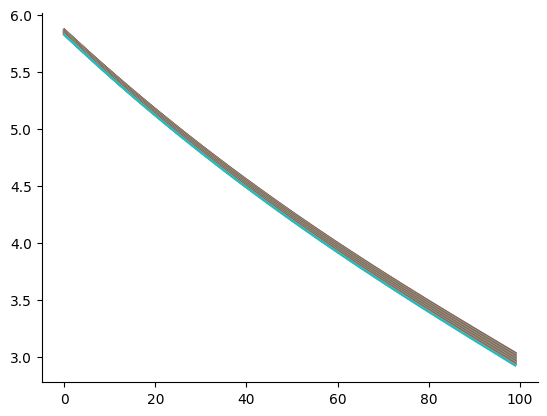

In [9]:
loc_start = np.abs(y2_grid - np.mean(θ_list)).argmin()
loc_twi = np.abs(y2_grid - 2 * np.mean(θ_list)).argmin()
loc_tri = np.abs(y2_grid - 3 * np.mean(θ_list)).argmin()
plt.plot(ϕ_list[0])
plt.show()

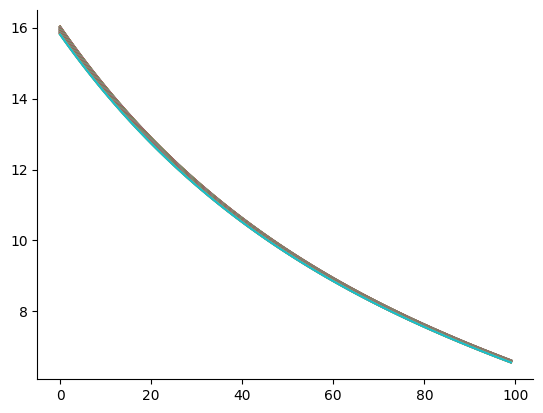

In [10]:
plt.plot(ems_list[0])
# plt.ylim(-6,6)
plt.show()

In [12]:
y1_grid_cap = np.arange(0., 2.1 + y1_step, y1_step)
loc_2 = np.abs(y1_grid - 2.).argmin()
ξp = 1
ϵ = 0.1
max_iter = 4000
dmg_weight = np.ones(len(γ3_list)) / len(γ3_list)
ϕ_weight = np.average(np.exp(-1 / ξp * ϕ_list), axis=0, weights=dmg_weight)

ϕ_equiv = -ξp * np.log(ϕ_weight)

(y1_mat_cap, y2_mat_cap) = np.meshgrid(y1_grid_cap, y2_grid, indexing='ij')
dy1 = y1_grid_cap[1] - y1_grid[0]
dy2 = y2_grid[1] - y2_grid[0]
num_y1 = len(y1_grid_cap)
num_y2 = len(y2_grid)
πd_o = np.ones((len(γ3_list), num_y1, num_y2)) / len(γ3_list)
πa_o = np.ones((len(θ_list), num_y1, num_y2)) / len(θ_list)
θ_mat = np.zeros((len(θ_list), num_y1, num_y2))
for i in range(len(θ_list)):
    θ_mat[i] = θ_list[i]
dΛ1 = γ1 + γ2 * y1_mat_cap

r1 = 1.5
r2 = 2.5
y_lower = 1.8
Intensity = r1 * (np.exp(r2 / 2 * (y1_mat_cap - y_lower)**2) -
                  1) * (y1_mat_cap >= y_lower)

# initiate v and control
tol = 1e-6
ems = η
ems_old = ems
lhs_error = 1
episode = 0
v0 = ϕ_equiv[:num_y1]
v_m = np.zeros(πd_o.shape)
for i in range(len(γ3_list)):
    v_m[i] = ϕ_list[i][loc_2]

while lhs_error > tol and episode < max_iter:
    v0_old = v0.copy()
    v0_dy1 = derivatives_2d(v0, 0, 1, hy1)
    v0_dy2 = derivatives_2d(v0, 1, 1, hy2)
    # updating controls
    weight = np.array([-1 / ξa * v0_dy2 * λ * ems_old * θ for θ in θ_list])
    weight = weight - np.max(weight, axis=0)
    πa = πa_o * np.exp(weight)
    πa[πa < 1e-15] = 1e-15
    πa = πa / np.sum(πa, axis=0)
    ems_new = -η / (v0_dy2 * λ * np.sum(θ_mat * πa, axis=0))
    ems_new[ems_new <= 1e-15] = 1e-15
    ems = ems_new * 0.05 + ems_old * 0.95
    #     print(np.min(ems))
    g_m = np.exp(1 / ξp * (v0 - v_m))
    # HJB coefficient
    A = -δ * np.ones(y1_mat_cap.shape) - Intensity * np.sum(πd_o * g_m, axis=0)
    B_y1 = y2_mat_cap
    B_y2 = λ * (-y2_mat_cap + ems * np.sum(θ_mat * πa, axis=0))
    C_yy1 = np.zeros(y1_mat_cap.shape)
    C_yy2 = np.zeros(y1_mat_cap.shape)
    D = η * np.log(ems) + (η - 1) / δ * dΛ1 * y2_mat_cap + ξa * np.sum(
        πa * (np.log(πa) - np.log(πa_o)), axis=0) + Intensity * np.sum(
            πd_o * g_m * v_m, axis=0) + ξp * Intensity * np.sum(
                πd_o * (1 - g_m + g_m * np.log(g_m)), axis=0)
    phi_mat = false_transient_one_iteration_python(
        A,
        B_y1,
        B_y2,
        C_yy1,
        C_yy2,
        D,
        v0,
        ϵ,
        hy1,
        hy2,
        bc=(np.zeros(num_y2), ϕ_equiv[num_y1 - 1], np.zeros(num_y1),
            np.zeros(num_y1)),
        impose_bc=(False, False, False, False))

    rhs = A * phi_mat + B_y1 * v0_dy1 + B_y2 * v0_dy2 + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((phi_mat - v0_old) / ϵ))
    v0 = phi_mat
    ems_old = ems
    episode += 1
    print('Episode: {:d}\t lhs error: {:.12f}\t rhs error: {:.12f}'.format(episode, lhs_error, rhs_error))

Episode: 1	 lhs error: 0.186031272914	 rhs error: 0.190949580404
Episode: 2	 lhs error: 0.196204463415	 rhs error: 0.200157292354
Episode: 3	 lhs error: 0.199528162523	 rhs error: 0.203041123081
Episode: 4	 lhs error: 0.197433627028	 rhs error: 0.203078178057
Episode: 5	 lhs error: 0.196412675405	 rhs error: 0.201596706942
Episode: 6	 lhs error: 0.194513238294	 rhs error: 0.199179765082
Episode: 7	 lhs error: 0.191374089786	 rhs error: 0.196196089264
Episode: 8	 lhs error: 0.189133543618	 rhs error: 0.192915992102
Episode: 9	 lhs error: 0.185776832331	 rhs error: 0.189472970331
Episode: 10	 lhs error: 0.183576268338	 rhs error: 0.185955011145
Episode: 11	 lhs error: 0.179042596811	 rhs error: 0.182469773934
Episode: 12	 lhs error: 0.175299427673	 rhs error: 0.179023963228
Episode: 13	 lhs error: 0.172009632110	 rhs error: 0.175648286928
Episode: 14	 lhs error: 0.168902949126	 rhs error: 0.172365756581
Episode: 15	 lhs error: 0.165942747886	 rhs error: 0.169188529308
Episode: 16	 lhs er

Episode: 125	 lhs error: 0.025418412282	 rhs error: 0.050083700981
Episode: 126	 lhs error: 0.025249887610	 rhs error: 0.050162429904
Episode: 127	 lhs error: 0.024038310001	 rhs error: 0.050237369319
Episode: 128	 lhs error: 0.023578090125	 rhs error: 0.050269124175
Episode: 129	 lhs error: 0.023697594145	 rhs error: 0.050289490897
Episode: 130	 lhs error: 0.023423475445	 rhs error: 0.050344537121
Episode: 131	 lhs error: 0.023170313110	 rhs error: 0.050367124102
Episode: 132	 lhs error: 0.022809034766	 rhs error: 0.050380056346
Episode: 133	 lhs error: 0.022454324562	 rhs error: 0.050382094250
Episode: 134	 lhs error: 0.022095019803	 rhs error: 0.050373471703
Episode: 135	 lhs error: 0.021716905561	 rhs error: 0.050354210340
Episode: 136	 lhs error: 0.021291156874	 rhs error: 0.050323904068
Episode: 137	 lhs error: 0.020528009872	 rhs error: 0.050281605384
Episode: 138	 lhs error: 0.021194032416	 rhs error: 0.050212657531
Episode: 139	 lhs error: 0.020407602721	 rhs error: 0.05017409

Episode: 249	 lhs error: 0.006395168738	 rhs error: 0.029710820661
Episode: 250	 lhs error: 0.006892763231	 rhs error: 0.029459281583
Episode: 251	 lhs error: 0.006880004717	 rhs error: 0.029199892172
Episode: 252	 lhs error: 0.006854894328	 rhs error: 0.028941585199
Episode: 253	 lhs error: 0.006825931926	 rhs error: 0.028684845537
Episode: 254	 lhs error: 0.006794768378	 rhs error: 0.028429850730
Episode: 255	 lhs error: 0.006762287729	 rhs error: 0.028176706958
Episode: 256	 lhs error: 0.006728892194	 rhs error: 0.027925479149
Episode: 257	 lhs error: 0.006694796524	 rhs error: 0.027676209972
Episode: 258	 lhs error: 0.006660161600	 rhs error: 0.027428930217
Episode: 259	 lhs error: 0.006625161519	 rhs error: 0.027183664398
Episode: 260	 lhs error: 0.005746028483	 rhs error: 0.026939194590
Episode: 261	 lhs error: 0.006559784382	 rhs error: 0.026724657179
Episode: 262	 lhs error: 0.006495358325	 rhs error: 0.026484691902
Episode: 263	 lhs error: 0.006473668869	 rhs error: 0.02624678

Episode: 373	 lhs error: 0.003201127924	 rhs error: 0.022366362414
Episode: 374	 lhs error: 0.003071457773	 rhs error: 0.022405048337
Episode: 375	 lhs error: 0.003064654174	 rhs error: 0.022450782618
Episode: 376	 lhs error: 0.003078579221	 rhs error: 0.022497341264
Episode: 377	 lhs error: 0.003094890334	 rhs error: 0.022544400796
Episode: 378	 lhs error: 0.003106293337	 rhs error: 0.022591752670
Episode: 379	 lhs error: 0.003064721640	 rhs error: 0.022639350283
Episode: 380	 lhs error: 0.003040344376	 rhs error: 0.022689523408
Episode: 381	 lhs error: 0.003047841973	 rhs error: 0.022741420015
Episode: 382	 lhs error: 0.003050465277	 rhs error: 0.022794262478
Episode: 383	 lhs error: 0.003049992098	 rhs error: 0.022847538764
Episode: 384	 lhs error: 0.003047476889	 rhs error: 0.022900939856
Episode: 385	 lhs error: 0.003043493791	 rhs error: 0.022954279718
Episode: 386	 lhs error: 0.003038356031	 rhs error: 0.023007443509
Episode: 387	 lhs error: 0.003282976388	 rhs error: 0.02305913

Episode: 496	 lhs error: 0.002309114232	 rhs error: 0.027122455946
Episode: 497	 lhs error: 0.002310482647	 rhs error: 0.027123069714
Episode: 498	 lhs error: 0.002309021953	 rhs error: 0.027127197627
Episode: 499	 lhs error: 0.002305822674	 rhs error: 0.027133959286
Episode: 500	 lhs error: 0.002301467894	 rhs error: 0.027142785935
Episode: 501	 lhs error: 0.002296543130	 rhs error: 0.027153251483
Episode: 502	 lhs error: 0.002291324874	 rhs error: 0.027165022112
Episode: 503	 lhs error: 0.002285926186	 rhs error: 0.027177827519
Episode: 504	 lhs error: 0.002280377630	 rhs error: 0.027191443707
Episode: 505	 lhs error: 0.002274666992	 rhs error: 0.027205682581
Episode: 506	 lhs error: 0.002268756913	 rhs error: 0.027220384955
Episode: 507	 lhs error: 0.002262586637	 rhs error: 0.027235415243
Episode: 508	 lhs error: 0.002256063324	 rhs error: 0.027250656604
Episode: 509	 lhs error: 0.002249037891	 rhs error: 0.027266005852
Episode: 510	 lhs error: 0.002241251470	 rhs error: 0.02728136

Episode: 620	 lhs error: 0.001872701580	 rhs error: 0.028404563093
Episode: 621	 lhs error: 0.001885462742	 rhs error: 0.028396574610
Episode: 622	 lhs error: 0.001876798322	 rhs error: 0.028394510655
Episode: 623	 lhs error: 0.001872725242	 rhs error: 0.028392649774
Episode: 624	 lhs error: 0.001869725663	 rhs error: 0.028391666832
Episode: 625	 lhs error: 0.001867145902	 rhs error: 0.028391590630
Episode: 626	 lhs error: 0.001864856170	 rhs error: 0.028392330323
Episode: 627	 lhs error: 0.001862868331	 rhs error: 0.028393778858
Episode: 628	 lhs error: 0.001861251023	 rhs error: 0.028395840622
Episode: 629	 lhs error: 0.001860112349	 rhs error: 0.028398439972
Episode: 630	 lhs error: 0.001859610702	 rhs error: 0.028401524296
Episode: 631	 lhs error: 0.001781816262	 rhs error: 0.028405833987
Episode: 632	 lhs error: 0.001841637393	 rhs error: 0.028401197396
Episode: 633	 lhs error: 0.001857112663	 rhs error: 0.028403496918
Episode: 634	 lhs error: 0.001869514706	 rhs error: 0.02840898

Episode: 744	 lhs error: 0.001533071707	 rhs error: 0.028457903153
Episode: 745	 lhs error: 0.001537284018	 rhs error: 0.028457437566
Episode: 746	 lhs error: 0.001524298076	 rhs error: 0.028458645595
Episode: 747	 lhs error: 0.001526349488	 rhs error: 0.028457237764
Episode: 748	 lhs error: 0.001525634413	 rhs error: 0.028457011774
Episode: 749	 lhs error: 0.001516349401	 rhs error: 0.028457319299
Episode: 750	 lhs error: 0.001524164398	 rhs error: 0.028455930489
Episode: 751	 lhs error: 0.001511205176	 rhs error: 0.028457220815
Episode: 752	 lhs error: 0.001515078442	 rhs error: 0.028455949726
Episode: 753	 lhs error: 0.001511246834	 rhs error: 0.028456328759
Episode: 754	 lhs error: 0.001711241979	 rhs error: 0.028454204850
Episode: 755	 lhs error: 0.001496235280	 rhs error: 0.028486314651
Episode: 756	 lhs error: 0.001515669290	 rhs error: 0.028484720667
Episode: 757	 lhs error: 0.001529394794	 rhs error: 0.028482683783
Episode: 758	 lhs error: 0.001489252926	 rhs error: 0.02848699

Episode: 868	 lhs error: 0.001247436099	 rhs error: 0.028566207703
Episode: 869	 lhs error: 0.001245450728	 rhs error: 0.028568852478
Episode: 870	 lhs error: 0.001243421574	 rhs error: 0.028571517268
Episode: 871	 lhs error: 0.001241355020	 rhs error: 0.028574194900
Episode: 872	 lhs error: 0.001239263630	 rhs error: 0.028576883730
Episode: 873	 lhs error: 0.001237131609	 rhs error: 0.028579589914
Episode: 874	 lhs error: 0.001234970955	 rhs error: 0.028582307582
Episode: 875	 lhs error: 0.001232775393	 rhs error: 0.028585040544
Episode: 876	 lhs error: 0.001230545064	 rhs error: 0.028587786765
Episode: 877	 lhs error: 0.001228271764	 rhs error: 0.028590545574
Episode: 878	 lhs error: 0.001226964403	 rhs error: 0.028593310751
Episode: 879	 lhs error: 0.001225659131	 rhs error: 0.028596083502
Episode: 880	 lhs error: 0.001224322278	 rhs error: 0.028598867810
Episode: 881	 lhs error: 0.001222953123	 rhs error: 0.028601661755
Episode: 882	 lhs error: 0.001221554831	 rhs error: 0.02860446

Episode: 992	 lhs error: 0.001049993825	 rhs error: 0.028858161542
Episode: 993	 lhs error: 0.001048747818	 rhs error: 0.028859503758
Episode: 994	 lhs error: 0.001047473975	 rhs error: 0.028860827749
Episode: 995	 lhs error: 0.001046180561	 rhs error: 0.028862137094
Episode: 996	 lhs error: 0.001044865937	 rhs error: 0.028863427297
Episode: 997	 lhs error: 0.001043523046	 rhs error: 0.028864696208
Episode: 998	 lhs error: 0.001042162478	 rhs error: 0.028865948361
Episode: 999	 lhs error: 0.001040770739	 rhs error: 0.028867177066
Episode: 1000	 lhs error: 0.001039354185	 rhs error: 0.028868389889
Episode: 1001	 lhs error: 0.001037913260	 rhs error: 0.028869586204
Episode: 1002	 lhs error: 0.001036454342	 rhs error: 0.028870766636
Episode: 1003	 lhs error: 0.001034965962	 rhs error: 0.028871925034
Episode: 1004	 lhs error: 0.001033451434	 rhs error: 0.028873067039
Episode: 1005	 lhs error: 0.001031918234	 rhs error: 0.028874193791
Episode: 1006	 lhs error: 0.001030362181	 rhs error: 0.0

Episode: 1116	 lhs error: 0.000892525808	 rhs error: 0.028922472113
Episode: 1117	 lhs error: 0.000891475415	 rhs error: 0.028922492133
Episode: 1118	 lhs error: 0.000890407367	 rhs error: 0.028922507886
Episode: 1119	 lhs error: 0.000889309541	 rhs error: 0.028922519033
Episode: 1120	 lhs error: 0.000888197040	 rhs error: 0.028922529328
Episode: 1121	 lhs error: 0.000887066906	 rhs error: 0.028922536830
Episode: 1122	 lhs error: 0.000885915526	 rhs error: 0.028922541677
Episode: 1123	 lhs error: 0.000884743078	 rhs error: 0.028922544418
Episode: 1124	 lhs error: 0.000883570199	 rhs error: 0.028922546026
Episode: 1125	 lhs error: 0.000882382801	 rhs error: 0.028922540802
Episode: 1126	 lhs error: 0.000881158179	 rhs error: 0.028922528630
Episode: 1127	 lhs error: 0.000879917305	 rhs error: 0.028922515473
Episode: 1128	 lhs error: 0.000878679698	 rhs error: 0.028922500166
Episode: 1129	 lhs error: 0.000877402144	 rhs error: 0.028922476239
Episode: 1130	 lhs error: 0.000876112100	 rhs er

Episode: 1240	 lhs error: 0.000763999536	 rhs error: 0.028915177497
Episode: 1241	 lhs error: 0.000762931067	 rhs error: 0.028915133113
Episode: 1242	 lhs error: 0.000761964117	 rhs error: 0.028915087135
Episode: 1243	 lhs error: 0.000761177284	 rhs error: 0.028915042334
Episode: 1244	 lhs error: 0.000760393605	 rhs error: 0.028915000902
Episode: 1245	 lhs error: 0.000759593614	 rhs error: 0.028914959107
Episode: 1246	 lhs error: 0.000758775252	 rhs error: 0.028914917941
Episode: 1247	 lhs error: 0.000757942334	 rhs error: 0.028914877928
Episode: 1248	 lhs error: 0.000757088675	 rhs error: 0.028914839051
Episode: 1249	 lhs error: 0.000756240977	 rhs error: 0.028914802669
Episode: 1250	 lhs error: 0.000755361517	 rhs error: 0.028914764417
Episode: 1251	 lhs error: 0.000754461186	 rhs error: 0.028914728422
Episode: 1252	 lhs error: 0.000753545837	 rhs error: 0.028914695044
Episode: 1253	 lhs error: 0.000752642953	 rhs error: 0.028914664672
Episode: 1254	 lhs error: 0.000751725066	 rhs er

Episode: 1364	 lhs error: 0.000657329450	 rhs error: 0.028917615354
Episode: 1365	 lhs error: 0.000656626640	 rhs error: 0.028917675226
Episode: 1366	 lhs error: 0.000655888520	 rhs error: 0.028917729779
Episode: 1367	 lhs error: 0.000655131385	 rhs error: 0.028917784164
Episode: 1368	 lhs error: 0.000654365744	 rhs error: 0.028917838400
Episode: 1369	 lhs error: 0.000653591199	 rhs error: 0.028917892650
Episode: 1370	 lhs error: 0.000652813180	 rhs error: 0.028917946283
Episode: 1371	 lhs error: 0.000652002369	 rhs error: 0.028917998277
Episode: 1372	 lhs error: 0.000651187061	 rhs error: 0.028918052073
Episode: 1373	 lhs error: 0.000650372756	 rhs error: 0.028918105927
Episode: 1374	 lhs error: 0.000649532877	 rhs error: 0.028918158248
Episode: 1375	 lhs error: 0.000648674045	 rhs error: 0.028918211171
Episode: 1376	 lhs error: 0.000647848991	 rhs error: 0.028918265787
Episode: 1377	 lhs error: 0.000647005473	 rhs error: 0.028918314861
Episode: 1378	 lhs error: 0.000646104062	 rhs er

Episode: 1488	 lhs error: 0.000554510359	 rhs error: 0.028920708337
Episode: 1489	 lhs error: 0.000553292162	 rhs error: 0.028920718474
Episode: 1490	 lhs error: 0.000552045724	 rhs error: 0.028920727715
Episode: 1491	 lhs error: 0.000550774480	 rhs error: 0.028920738427
Episode: 1492	 lhs error: 0.000549519038	 rhs error: 0.028920752221
Episode: 1493	 lhs error: 0.000548282926	 rhs error: 0.028920765266
Episode: 1494	 lhs error: 0.000546976954	 rhs error: 0.028920774052
Episode: 1495	 lhs error: 0.000545639826	 rhs error: 0.028920786557
Episode: 1496	 lhs error: 0.000544373948	 rhs error: 0.028920804533
Episode: 1497	 lhs error: 0.000543097270	 rhs error: 0.028920817370
Episode: 1498	 lhs error: 0.000541758640	 rhs error: 0.028920825905
Episode: 1499	 lhs error: 0.000540398388	 rhs error: 0.028920836681
Episode: 1500	 lhs error: 0.000539017240	 rhs error: 0.028920851123
Episode: 1501	 lhs error: 0.000537723480	 rhs error: 0.028920869572
Episode: 1502	 lhs error: 0.000536364273	 rhs er

Episode: 1612	 lhs error: 0.000340579677	 rhs error: 0.028936485210
Episode: 1613	 lhs error: 0.000341272055	 rhs error: 0.028927284025
Episode: 1614	 lhs error: 0.000342038349	 rhs error: 0.028919244709
Episode: 1615	 lhs error: 0.000341465890	 rhs error: 0.028912174435
Episode: 1616	 lhs error: 0.000340127137	 rhs error: 0.028906111402
Episode: 1617	 lhs error: 0.000676767573	 rhs error: 0.028899484997
Episode: 1618	 lhs error: 0.000331318334	 rhs error: 0.028910739763
Episode: 1619	 lhs error: 0.000329934330	 rhs error: 0.028905231767
Episode: 1620	 lhs error: 0.000329128907	 rhs error: 0.028900533519
Episode: 1621	 lhs error: 0.000328034669	 rhs error: 0.028896398419
Episode: 1622	 lhs error: 0.000326519882	 rhs error: 0.028892776283
Episode: 1623	 lhs error: 0.000324794701	 rhs error: 0.028889623193
Episode: 1624	 lhs error: 0.000322936945	 rhs error: 0.028886872320
Episode: 1625	 lhs error: 0.000320986118	 rhs error: 0.028884459073
Episode: 1626	 lhs error: 0.000319014478	 rhs er

Episode: 1736	 lhs error: 0.000165346386	 rhs error: 0.028799656145
Episode: 1737	 lhs error: 0.000165006334	 rhs error: 0.028798981339
Episode: 1738	 lhs error: 0.000164688136	 rhs error: 0.028798441532
Episode: 1739	 lhs error: 0.000164411898	 rhs error: 0.028798004990
Episode: 1740	 lhs error: 0.000164169260	 rhs error: 0.028797650301
Episode: 1741	 lhs error: 0.000163959619	 rhs error: 0.028797355591
Episode: 1742	 lhs error: 0.000163755985	 rhs error: 0.028797108141
Episode: 1743	 lhs error: 0.000163586074	 rhs error: 0.028796894135
Episode: 1744	 lhs error: 0.000163439563	 rhs error: 0.028796712784
Episode: 1745	 lhs error: 0.000163318436	 rhs error: 0.028796555808
Episode: 1746	 lhs error: 0.000163231200	 rhs error: 0.028796416839
Episode: 1747	 lhs error: 0.000163141614	 rhs error: 0.028796295324
Episode: 1748	 lhs error: 0.000163074446	 rhs error: 0.028796181665
Episode: 1749	 lhs error: 0.000162982349	 rhs error: 0.028796078172
Episode: 1750	 lhs error: 0.000162897990	 rhs er

Episode: 1860	 lhs error: 0.000249260248	 rhs error: 0.028705752864
Episode: 1861	 lhs error: 0.000244045999	 rhs error: 0.028702696531
Episode: 1862	 lhs error: 0.000238816609	 rhs error: 0.028699677414
Episode: 1863	 lhs error: 0.000233582238	 rhs error: 0.028696697336
Episode: 1864	 lhs error: 0.000228401864	 rhs error: 0.028693752498
Episode: 1865	 lhs error: 0.000223090709	 rhs error: 0.028690850492
Episode: 1866	 lhs error: 0.000217849338	 rhs error: 0.028688004145
Episode: 1867	 lhs error: 0.000212658498	 rhs error: 0.028685207922
Episode: 1868	 lhs error: 0.000207497438	 rhs error: 0.028682462446
Episode: 1869	 lhs error: 0.000202325636	 rhs error: 0.028679773408
Episode: 1870	 lhs error: 0.000197306136	 rhs error: 0.028677145334
Episode: 1871	 lhs error: 0.000192110084	 rhs error: 0.028674572800
Episode: 1872	 lhs error: 0.000187171904	 rhs error: 0.028672079398
Episode: 1873	 lhs error: 0.000182364320	 rhs error: 0.028669639383
Episode: 1874	 lhs error: 0.000177564512	 rhs er

Episode: 1984	 lhs error: 0.000109010952	 rhs error: 0.028687061718
Episode: 1985	 lhs error: 0.000108456640	 rhs error: 0.028688220747
Episode: 1986	 lhs error: 0.000107983578	 rhs error: 0.028689388338
Episode: 1987	 lhs error: 0.000107575741	 rhs error: 0.028690560984
Episode: 1988	 lhs error: 0.000107035274	 rhs error: 0.028691736356
Episode: 1989	 lhs error: 0.000106319285	 rhs error: 0.028692921812
Episode: 1990	 lhs error: 0.000105845598	 rhs error: 0.028694124144
Episode: 1991	 lhs error: 0.000105255136	 rhs error: 0.028695332040
Episode: 1992	 lhs error: 0.000104639690	 rhs error: 0.028696551234
Episode: 1993	 lhs error: 0.000104151080	 rhs error: 0.028697782540
Episode: 1994	 lhs error: 0.000103661797	 rhs error: 0.028699020087
Episode: 1995	 lhs error: 0.000103587612	 rhs error: 0.028700264423
Episode: 1996	 lhs error: 0.000103548260	 rhs error: 0.028701527511
Episode: 1997	 lhs error: 0.000103497518	 rhs error: 0.028702798571
Episode: 1998	 lhs error: 0.000103577938	 rhs er

Episode: 2108	 lhs error: 0.000089335800	 rhs error: 0.028809196893
Episode: 2109	 lhs error: 0.000086504514	 rhs error: 0.028809558668
Episode: 2110	 lhs error: 0.000084067824	 rhs error: 0.028809929016
Episode: 2111	 lhs error: 0.000082060720	 rhs error: 0.028810296508
Episode: 2112	 lhs error: 0.000081544710	 rhs error: 0.028810658727
Episode: 2113	 lhs error: 0.000081111297	 rhs error: 0.028811012912
Episode: 2114	 lhs error: 0.000080684081	 rhs error: 0.028811355945
Episode: 2115	 lhs error: 0.000080190020	 rhs error: 0.028811687190
Episode: 2116	 lhs error: 0.000079797795	 rhs error: 0.028812009663
Episode: 2117	 lhs error: 0.000079418256	 rhs error: 0.028812315077
Episode: 2118	 lhs error: 0.000078924298	 rhs error: 0.028812603461
Episode: 2119	 lhs error: 0.000078453565	 rhs error: 0.028812881742
Episode: 2120	 lhs error: 0.000078007785	 rhs error: 0.028813147252
Episode: 2121	 lhs error: 0.000077533827	 rhs error: 0.028813399700
Episode: 2122	 lhs error: 0.000077049585	 rhs er

Episode: 2232	 lhs error: 0.000154233720	 rhs error: 0.028828130039
Episode: 2233	 lhs error: 0.000360515314	 rhs error: 0.028826558509
Episode: 2234	 lhs error: 0.000924112929	 rhs error: 0.028815142845
Episode: 2235	 lhs error: 0.000273220736	 rhs error: 0.028834846138
Episode: 2236	 lhs error: 0.000181438975	 rhs error: 0.028835791436
Episode: 2237	 lhs error: 0.000160566106	 rhs error: 0.028831954798
Episode: 2238	 lhs error: 0.000152336265	 rhs error: 0.028827257412
Episode: 2239	 lhs error: 0.000148617183	 rhs error: 0.028822517556
Episode: 2240	 lhs error: 0.000146684942	 rhs error: 0.028817989690
Episode: 2241	 lhs error: 0.000145470220	 rhs error: 0.028813738234
Episode: 2242	 lhs error: 0.000144441228	 rhs error: 0.028809756981
Episode: 2243	 lhs error: 0.000143525394	 rhs error: 0.028806010094
Episode: 2244	 lhs error: 0.000142794882	 rhs error: 0.028802461537
Episode: 2245	 lhs error: 0.000142177941	 rhs error: 0.028799083883
Episode: 2246	 lhs error: 0.000141629257	 rhs er

Episode: 2355	 lhs error: 0.000107634375	 rhs error: 0.028548992714
Episode: 2356	 lhs error: 0.000107728731	 rhs error: 0.028547070206
Episode: 2357	 lhs error: 0.000107809375	 rhs error: 0.028545298050
Episode: 2358	 lhs error: 0.000107903189	 rhs error: 0.028543650374
Episode: 2359	 lhs error: 0.000108043680	 rhs error: 0.028542107301
Episode: 2360	 lhs error: 0.000108254001	 rhs error: 0.028540654549
Episode: 2361	 lhs error: 0.000108422457	 rhs error: 0.028539282440
Episode: 2362	 lhs error: 0.000108623355	 rhs error: 0.028537975668
Episode: 2363	 lhs error: 0.000108878062	 rhs error: 0.028536726358
Episode: 2364	 lhs error: 0.000109137221	 rhs error: 0.028535529840
Episode: 2365	 lhs error: 0.000434264361	 rhs error: 0.028535087681
Episode: 2366	 lhs error: 0.000908237599	 rhs error: 0.028526533051
Episode: 2367	 lhs error: 0.000195440633	 rhs error: 0.028546456181
Episode: 2368	 lhs error: 0.000126780012	 rhs error: 0.028547764752
Episode: 2369	 lhs error: 0.000112712444	 rhs er

Episode: 2479	 lhs error: 0.000087584511	 rhs error: 0.028483597734
Episode: 2480	 lhs error: 0.000087830551	 rhs error: 0.028483593852
Episode: 2481	 lhs error: 0.000347414786	 rhs error: 0.028484189862
Episode: 2482	 lhs error: 0.001055662450	 rhs error: 0.028479279496
Episode: 2483	 lhs error: 0.000198005820	 rhs error: 0.028502823766
Episode: 2484	 lhs error: 0.000104113817	 rhs error: 0.028505085367
Episode: 2485	 lhs error: 0.000091698932	 rhs error: 0.028502714803
Episode: 2486	 lhs error: 0.000087477667	 rhs error: 0.028499678458
Episode: 2487	 lhs error: 0.000086177542	 rhs error: 0.028496797252
Episode: 2488	 lhs error: 0.000085730462	 rhs error: 0.028494309950
Episode: 2489	 lhs error: 0.000085364187	 rhs error: 0.028492233756
Episode: 2490	 lhs error: 0.000084877319	 rhs error: 0.028490512838
Episode: 2491	 lhs error: 0.000084389455	 rhs error: 0.028489084636
Episode: 2492	 lhs error: 0.000083988120	 rhs error: 0.028487902047
Episode: 2493	 lhs error: 0.000083695820	 rhs er

Episode: 2603	 lhs error: 0.000074065038	 rhs error: 0.028502620503
Episode: 2604	 lhs error: 0.000073161249	 rhs error: 0.028500167580
Episode: 2605	 lhs error: 0.000072865781	 rhs error: 0.028498048635
Episode: 2606	 lhs error: 0.000072615128	 rhs error: 0.028496282017
Episode: 2607	 lhs error: 0.000072276819	 rhs error: 0.028494819708
Episode: 2608	 lhs error: 0.000071924608	 rhs error: 0.028493606819
Episode: 2609	 lhs error: 0.000071617870	 rhs error: 0.028492601428
Episode: 2610	 lhs error: 0.000071371516	 rhs error: 0.028491772790
Episode: 2611	 lhs error: 0.000071200726	 rhs error: 0.028491095604
Episode: 2612	 lhs error: 0.000071055155	 rhs error: 0.028490550220
Episode: 2613	 lhs error: 0.000070943265	 rhs error: 0.028490114325
Episode: 2614	 lhs error: 0.000070883188	 rhs error: 0.028489770025
Episode: 2615	 lhs error: 0.000070877491	 rhs error: 0.028489504481
Episode: 2616	 lhs error: 0.000070906404	 rhs error: 0.028489307711
Episode: 2617	 lhs error: 0.000070947343	 rhs er

Episode: 2727	 lhs error: 0.000175854324	 rhs error: 0.028505913626
Episode: 2728	 lhs error: 0.000069472066	 rhs error: 0.028508523598
Episode: 2729	 lhs error: 0.000063977534	 rhs error: 0.028506733810
Episode: 2730	 lhs error: 0.000062176085	 rhs error: 0.028504294459
Episode: 2731	 lhs error: 0.000061586030	 rhs error: 0.028501947691
Episode: 2732	 lhs error: 0.000061361576	 rhs error: 0.028499921402
Episode: 2733	 lhs error: 0.000061101498	 rhs error: 0.028498233862
Episode: 2734	 lhs error: 0.000060758897	 rhs error: 0.028496831020
Episode: 2735	 lhs error: 0.000060412483	 rhs error: 0.028495657111
Episode: 2736	 lhs error: 0.000060115122	 rhs error: 0.028494674975
Episode: 2737	 lhs error: 0.000059877316	 rhs error: 0.028493860541
Episode: 2738	 lhs error: 0.000059689086	 rhs error: 0.028493194253
Episode: 2739	 lhs error: 0.000059537160	 rhs error: 0.028492657360
Episode: 2740	 lhs error: 0.000059425412	 rhs error: 0.028492231410
Episode: 2741	 lhs error: 0.000059348868	 rhs er

Episode: 2851	 lhs error: 0.000054460183	 rhs error: 0.028497979483
Episode: 2852	 lhs error: 0.000054408787	 rhs error: 0.028497799827
Episode: 2853	 lhs error: 0.000054359984	 rhs error: 0.028497670621
Episode: 2854	 lhs error: 0.000054323123	 rhs error: 0.028497580654
Episode: 2855	 lhs error: 0.000416332465	 rhs error: 0.028498199408
Episode: 2856	 lhs error: 0.000892139011	 rhs error: 0.028491026519
Episode: 2857	 lhs error: 0.000167928965	 rhs error: 0.028511801094
Episode: 2858	 lhs error: 0.000059038240	 rhs error: 0.028514212354
Episode: 2859	 lhs error: 0.000056176837	 rhs error: 0.028512546529
Episode: 2860	 lhs error: 0.000055134776	 rhs error: 0.028510203507
Episode: 2861	 lhs error: 0.000054695865	 rhs error: 0.028507904825
Episode: 2862	 lhs error: 0.000054521096	 rhs error: 0.028505892785
Episode: 2863	 lhs error: 0.000054342197	 rhs error: 0.028504208099
Episode: 2864	 lhs error: 0.000054135425	 rhs error: 0.028502811422
Episode: 2865	 lhs error: 0.000053959251	 rhs er

Episode: 2975	 lhs error: 0.000049444202	 rhs error: 0.028503012884
Episode: 2976	 lhs error: 0.000049309178	 rhs error: 0.028501874804
Episode: 2977	 lhs error: 0.000049176247	 rhs error: 0.028500921182
Episode: 2978	 lhs error: 0.000049047359	 rhs error: 0.028500130258
Episode: 2979	 lhs error: 0.000048923199	 rhs error: 0.028499479543
Episode: 2980	 lhs error: 0.000048803536	 rhs error: 0.028498948176
Episode: 2981	 lhs error: 0.000048687749	 rhs error: 0.028498519407
Episode: 2982	 lhs error: 0.000048576234	 rhs error: 0.028498181172
Episode: 2983	 lhs error: 0.000048469857	 rhs error: 0.028497922430
Episode: 2984	 lhs error: 0.000048367937	 rhs error: 0.028497730561
Episode: 2985	 lhs error: 0.000048270223	 rhs error: 0.028497596798
Episode: 2986	 lhs error: 0.000048176887	 rhs error: 0.028497514563
Episode: 2987	 lhs error: 0.000048089147	 rhs error: 0.028497477866
Episode: 2988	 lhs error: 0.000344185991	 rhs error: 0.028498042511
Episode: 2989	 lhs error: 0.000960342261	 rhs er

Episode: 3099	 lhs error: 0.000044199705	 rhs error: 0.028499802146
Episode: 3100	 lhs error: 0.000044067294	 rhs error: 0.028499657685
Episode: 3101	 lhs error: 0.000043934927	 rhs error: 0.028499559707
Episode: 3102	 lhs error: 0.000043801666	 rhs error: 0.028499500359
Episode: 3103	 lhs error: 0.000043664836	 rhs error: 0.028499473301
Episode: 3104	 lhs error: 0.000406718701	 rhs error: 0.028500140859
Episode: 3105	 lhs error: 0.000855836011	 rhs error: 0.028493682202
Episode: 3106	 lhs error: 0.000176886277	 rhs error: 0.028513176567
Episode: 3107	 lhs error: 0.000042693639	 rhs error: 0.028515786844
Episode: 3108	 lhs error: 0.000044382269	 rhs error: 0.028514105606
Episode: 3109	 lhs error: 0.000048051300	 rhs error: 0.028511766936
Episode: 3110	 lhs error: 0.000049787480	 rhs error: 0.028509505846
Episode: 3111	 lhs error: 0.000048673446	 rhs error: 0.028507535925
Episode: 3112	 lhs error: 0.000047354349	 rhs error: 0.028505884733
Episode: 3113	 lhs error: 0.000046406429	 rhs er

Episode: 3223	 lhs error: 0.000052016514	 rhs error: 0.028508751849
Episode: 3224	 lhs error: 0.000051039953	 rhs error: 0.028506664379
Episode: 3225	 lhs error: 0.000049826813	 rhs error: 0.028504906993
Episode: 3226	 lhs error: 0.000048799797	 rhs error: 0.028503437890
Episode: 3227	 lhs error: 0.000047733702	 rhs error: 0.028502209718
Episode: 3228	 lhs error: 0.000046484664	 rhs error: 0.028501185969
Episode: 3229	 lhs error: 0.000045064612	 rhs error: 0.028500338136
Episode: 3230	 lhs error: 0.000043403460	 rhs error: 0.028499641129
Episode: 3231	 lhs error: 0.000041516426	 rhs error: 0.028499075322
Episode: 3232	 lhs error: 0.000041080165	 rhs error: 0.028498624226
Episode: 3233	 lhs error: 0.000040889048	 rhs error: 0.028498269353
Episode: 3234	 lhs error: 0.000040690340	 rhs error: 0.028497998655
Episode: 3235	 lhs error: 0.000040502899	 rhs error: 0.028497798860
Episode: 3236	 lhs error: 0.000040326209	 rhs error: 0.028497654919
Episode: 3237	 lhs error: 0.000040163590	 rhs er

Episode: 3347	 lhs error: 0.000204153863	 rhs error: 0.028512582944
Episode: 3348	 lhs error: 0.000032368686	 rhs error: 0.028515924411
Episode: 3349	 lhs error: 0.000035896252	 rhs error: 0.028514257824
Episode: 3350	 lhs error: 0.000047012538	 rhs error: 0.028511882721
Episode: 3351	 lhs error: 0.000049444080	 rhs error: 0.028509559615
Episode: 3352	 lhs error: 0.000049128073	 rhs error: 0.028507510627
Episode: 3353	 lhs error: 0.000048501479	 rhs error: 0.028505766565
Episode: 3354	 lhs error: 0.000048012882	 rhs error: 0.028504292247
Episode: 3355	 lhs error: 0.000047414628	 rhs error: 0.028503044762
Episode: 3356	 lhs error: 0.000046626151	 rhs error: 0.028501991702
Episode: 3357	 lhs error: 0.000045478685	 rhs error: 0.028501105988
Episode: 3358	 lhs error: 0.000044034061	 rhs error: 0.028500368152
Episode: 3359	 lhs error: 0.000042447005	 rhs error: 0.028499760441
Episode: 3360	 lhs error: 0.000040692336	 rhs error: 0.028499264096
Episode: 3361	 lhs error: 0.000038926905	 rhs er

Episode: 3471	 lhs error: 0.000932449263	 rhs error: 0.028488154890
Episode: 3472	 lhs error: 0.000165730601	 rhs error: 0.028509702792
Episode: 3473	 lhs error: 0.000031443240	 rhs error: 0.028511909319
Episode: 3474	 lhs error: 0.000043485386	 rhs error: 0.028509946755
Episode: 3475	 lhs error: 0.000052719828	 rhs error: 0.028507410184
Episode: 3476	 lhs error: 0.000054189209	 rhs error: 0.028505002450
Episode: 3477	 lhs error: 0.000053352585	 rhs error: 0.028502913925
Episode: 3478	 lhs error: 0.000052537040	 rhs error: 0.028501155709
Episode: 3479	 lhs error: 0.000052009257	 rhs error: 0.028499680922
Episode: 3480	 lhs error: 0.000051491018	 rhs error: 0.028498441321
Episode: 3481	 lhs error: 0.000050753281	 rhs error: 0.028497400342
Episode: 3482	 lhs error: 0.000049816143	 rhs error: 0.028496531272
Episode: 3483	 lhs error: 0.000048576629	 rhs error: 0.028495810225
Episode: 3484	 lhs error: 0.000046998252	 rhs error: 0.028495219201
Episode: 3485	 lhs error: 0.000045245370	 rhs er

Episode: 3595	 lhs error: 0.000030992968	 rhs error: 0.028501096311
Episode: 3596	 lhs error: 0.000030598706	 rhs error: 0.028501031950
Episode: 3597	 lhs error: 0.000030382665	 rhs error: 0.028501009949
Episode: 3598	 lhs error: 0.000030143444	 rhs error: 0.028501021801
Episode: 3599	 lhs error: 0.000029930671	 rhs error: 0.028501064001
Episode: 3600	 lhs error: 0.000338827907	 rhs error: 0.028501685230
Episode: 3601	 lhs error: 0.001003326713	 rhs error: 0.028497205768
Episode: 3602	 lhs error: 0.000185329936	 rhs error: 0.028519460361
Episode: 3603	 lhs error: 0.000044095467	 rhs error: 0.028521692264
Episode: 3604	 lhs error: 0.000039945527	 rhs error: 0.028519491667
Episode: 3605	 lhs error: 0.000049760243	 rhs error: 0.028516694808
Episode: 3606	 lhs error: 0.000051170925	 rhs error: 0.028514066638
Episode: 3607	 lhs error: 0.000050016479	 rhs error: 0.028511808052
Episode: 3608	 lhs error: 0.000048567787	 rhs error: 0.028509926507
Episode: 3609	 lhs error: 0.000047229112	 rhs er

Episode: 3719	 lhs error: 0.000049099525	 rhs error: 0.028507949136
Episode: 3720	 lhs error: 0.000048424585	 rhs error: 0.028506647246
Episode: 3721	 lhs error: 0.000047471081	 rhs error: 0.028505546797
Episode: 3722	 lhs error: 0.000046150863	 rhs error: 0.028504621632
Episode: 3723	 lhs error: 0.000044557383	 rhs error: 0.028503851324
Episode: 3724	 lhs error: 0.000042716101	 rhs error: 0.028503216203
Episode: 3725	 lhs error: 0.000040809852	 rhs error: 0.028502699477
Episode: 3726	 lhs error: 0.000038903691	 rhs error: 0.028502282794
Episode: 3727	 lhs error: 0.000037024398	 rhs error: 0.028501949233
Episode: 3728	 lhs error: 0.000035110281	 rhs error: 0.028501684004
Episode: 3729	 lhs error: 0.000033241341	 rhs error: 0.028501476444
Episode: 3730	 lhs error: 0.000031546572	 rhs error: 0.028501316204
Episode: 3731	 lhs error: 0.000323491780	 rhs error: 0.028501713599
Episode: 3732	 lhs error: 0.000954162752	 rhs error: 0.028496699226
Episode: 3733	 lhs error: 0.000209103270	 rhs er

Episode: 3843	 lhs error: 0.000052694549	 rhs error: 0.028508260819
Episode: 3844	 lhs error: 0.000051334613	 rhs error: 0.028506032860
Episode: 3845	 lhs error: 0.000049738180	 rhs error: 0.028504168048
Episode: 3846	 lhs error: 0.000048529953	 rhs error: 0.028502619592
Episode: 3847	 lhs error: 0.000047309445	 rhs error: 0.028501330651
Episode: 3848	 lhs error: 0.000045849656	 rhs error: 0.028500260806
Episode: 3849	 lhs error: 0.000044267893	 rhs error: 0.028499380497
Episode: 3850	 lhs error: 0.000042459245	 rhs error: 0.028498661177
Episode: 3851	 lhs error: 0.000040510403	 rhs error: 0.028498081197
Episode: 3852	 lhs error: 0.000038475663	 rhs error: 0.028497620457
Episode: 3853	 lhs error: 0.000036353555	 rhs error: 0.028497260810
Episode: 3854	 lhs error: 0.000034130152	 rhs error: 0.028496987114
Episode: 3855	 lhs error: 0.000032001370	 rhs error: 0.028496787476
Episode: 3856	 lhs error: 0.000029946178	 rhs error: 0.028496647504
Episode: 3857	 lhs error: 0.000028029863	 rhs er

Episode: 3967	 lhs error: 0.000035078654	 rhs error: 0.028496685458
Episode: 3968	 lhs error: 0.000033351068	 rhs error: 0.028496453139
Episode: 3969	 lhs error: 0.000031601114	 rhs error: 0.028496284081
Episode: 3970	 lhs error: 0.000029856707	 rhs error: 0.028496168233
Episode: 3971	 lhs error: 0.000028150416	 rhs error: 0.028496096749
Episode: 3972	 lhs error: 0.000026543002	 rhs error: 0.028496061682
Episode: 3973	 lhs error: 0.000355518266	 rhs error: 0.028496636078
Episode: 3974	 lhs error: 0.000971877850	 rhs error: 0.028491232945
Episode: 3975	 lhs error: 0.000192022586	 rhs error: 0.028513316076
Episode: 3976	 lhs error: 0.000041196231	 rhs error: 0.028515850656
Episode: 3977	 lhs error: 0.000038551786	 rhs error: 0.028513778330
Episode: 3978	 lhs error: 0.000049226886	 rhs error: 0.028511078981
Episode: 3979	 lhs error: 0.000051405066	 rhs error: 0.028508505904
Episode: 3980	 lhs error: 0.000050667753	 rhs error: 0.028506267705
Episode: 3981	 lhs error: 0.000049729720	 rhs er

In [17]:
np.save(f"ems_{λ}_{y_lower}", ems)
np.save(f"v_{λ}_{y_lower}", v0)

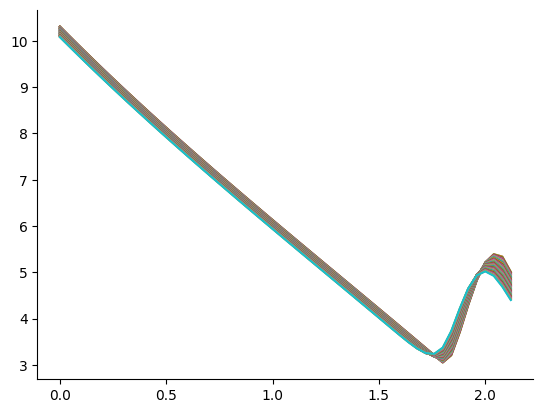

In [16]:
plt.plot(y1_grid_cap, ems)
plt.show()

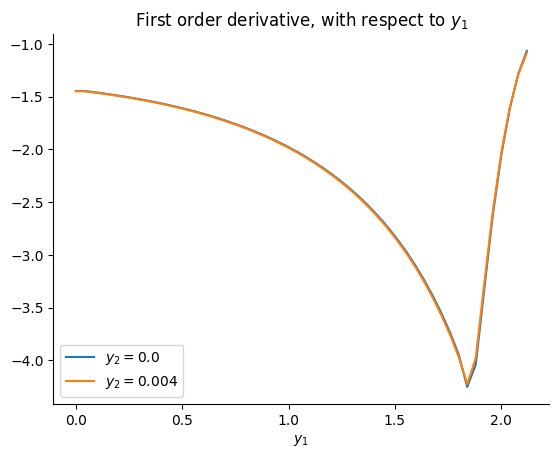

In [18]:
plt.title("First order derivative, with respect to $y_1$")
plt.plot(y1_grid_cap, v0_dy1[:,0], label=r"$y_2 = {}$".format(y2_grid[0]))
plt.plot(y1_grid_cap, v0_dy1[:,4], label=r"$y_2 = {}$".format(y2_grid[4]))
plt.xlabel(r"$y_1$")
plt.legend()
# plt.savefig("dv_dy1")
plt.show()

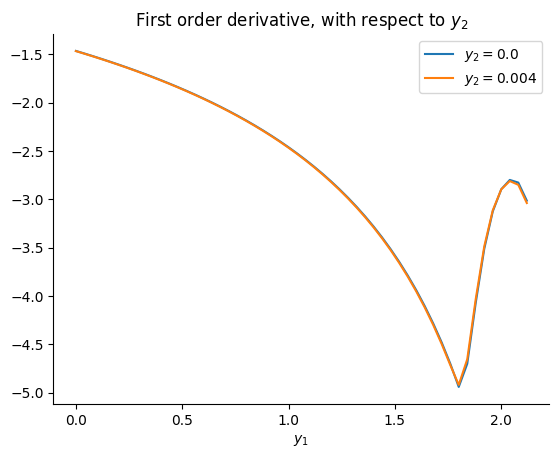

In [19]:
plt.title("First order derivative, with respect to $y_2$")
plt.plot(y1_grid_cap, v0_dy2[:,0], label=r"$y_2 = {}$".format(y2_grid[0]))
plt.plot(y1_grid_cap, v0_dy2[:,4], label=r"$y_2 = {}$".format(y2_grid[4]))
plt.xlabel(r"$y_1$")
plt.legend()
# plt.savefig("dv_dy2")
plt.show()

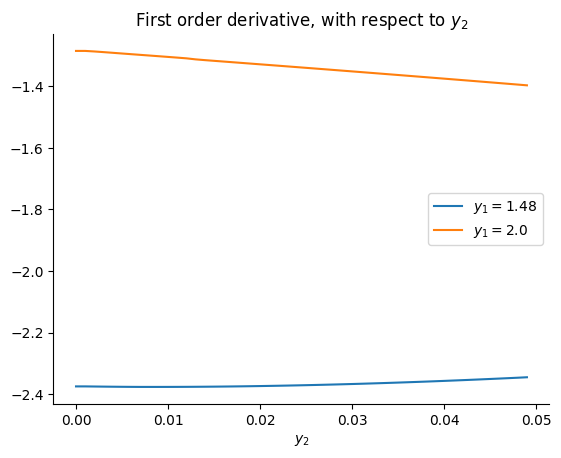

In [13]:
plt.title("First order derivative, with respect to $y_2$")
plt.plot(y2_grid, v0_dy2[37], label=r"$y_1 = {}$".format(y1_grid_cap[37]))
plt.plot(y2_grid, v0_dy2[-4], label=r"$y_1 = {}$".format(y1_grid_cap[-4]))
plt.xlabel(r"$y_2$")
plt.legend()
# plt.savefig("dv_dy2_y2")
plt.show()

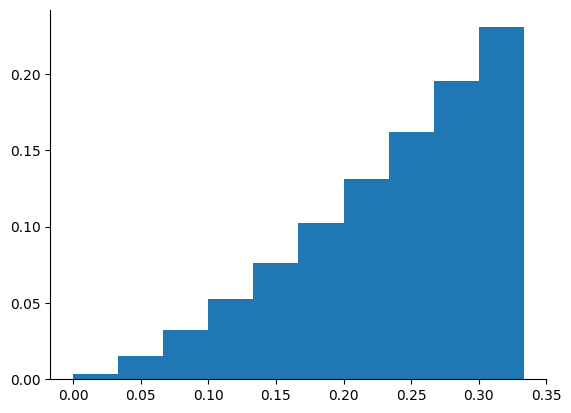

In [14]:
g_i = g_m[:, -1, 2]
plt.hist(γ3_list, weights= g_i/ np.sum(g_i, axis=0))
plt.show()

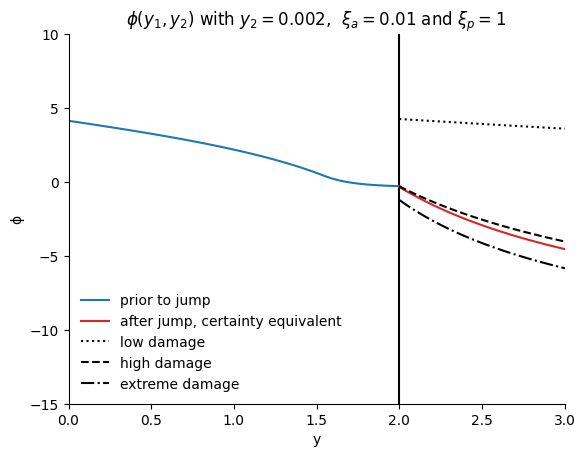

In [15]:
#
plt.plot(y1_grid[:loc_2 + 1],
         phi_mat[:loc_2 + 1, 2],
         color="tab:blue",
         label="prior to jump")
plt.plot(y1_grid[loc_2:],
         ϕ_equiv[loc_2:][:, 2],
         color="tab:red",
         label="after jump, certainty equivalent")
plt.plot(y1_grid[loc_2:],
         ϕ_list[0][loc_2:, 2],
         color="black",
         linestyle=":",
         label="low damage")
plt.plot(y1_grid[loc_2:],
         ϕ_list[10][loc_2:, 2],
         color="black",
         linestyle="--",
         label="high damage")
plt.plot(y1_grid[loc_2:],
         ϕ_list[-1][loc_2:, 2],
         color="black",
         linestyle="-.",
         label="extreme damage")

plt.legend(frameon=False)
plt.title("$ϕ(y_1, y_2)$ with $y_2 = 0.002$,  $ξ_a = 0.01$ and $ξ_p = 1$")
plt.vlines(2, ymax=10, ymin=-15, color="black")
plt.xlim(0, 3)
plt.ylim(-15, 10)
plt.xlabel("y")
plt.ylabel("ϕ")
# plt.savefig("./paper_plots/2_state_value_function.png", dpi=400, facecolor="w", edgecolor="w", bbox_inches="tight")
plt.show()

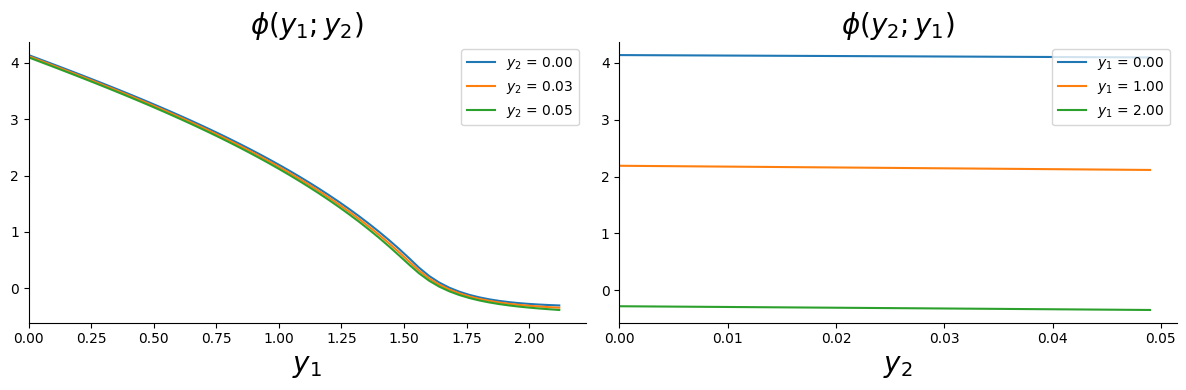

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(y1_mat_cap[:,0], v0[:,0], label="$y_2$ = {:.2f}".format(y2_mat[0,0]))
ax1.plot(y1_mat_cap[:,0], v0[:,int(n_y2/2)], label="$y_2$ = {:.2f}".format(y2_mat[0,int(n_y2/2)]))
ax1.plot(y1_mat_cap[:,0], v0[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$ϕ(y_1; y_2)$', size=20)
ax1.set_xlabel("$y_1$", size=20)
ax1.legend()
# ax1.tick_params(labelsize=20)
ax1.set_xlim(0)
# ax1.set_ylim(-0.18, 0.05)
ax2.plot(y2_mat[0], v0[0], label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.plot(y2_mat[int(n_y1 / 4)], v0[int(n_y1/4)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/4),0]))
ax2.plot(y2_mat[int(n_y1 / 2)], v0[int(n_y1/2)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/2),0]))
# ax2.plot(y2_mat[-1], v0[-1], label="$y_1$ = {:.2f}".format(y1_mat[-1,0]))
ax2.set_title('$ϕ(y_2; y_1)$', size=20)
ax2.set_xlabel('$y_2$', size=20)
ax2.set_xlim(0)
ax2.legend()
# ax2.set_ylim(-0.18, 0.05)
fig.tight_layout()
# plt.savefig("ϕ.png", bbox_inches="tight", facecolor="w", edgecolor="w")
plt.show()

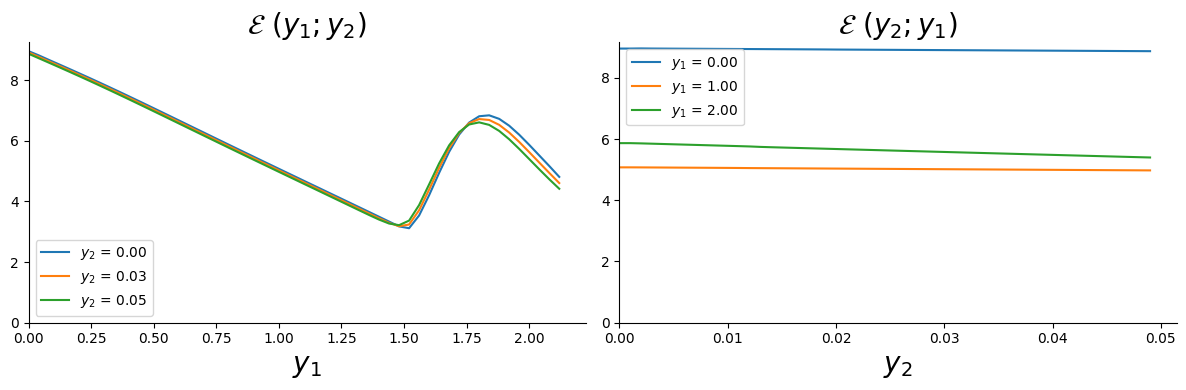

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(y1_mat_cap[:,0], ems[:,0], label="$y_2$ = {:.2f}".format(y2_mat[0,0]))
ax1.plot(y1_mat_cap[:,0], ems[:,int(n_y2/2)], label="$y_2$ = {:.2f}".format(y2_mat[0,int(n_y2/2)]))
ax1.plot(y1_mat_cap[:,0], ems[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$\mathcal{E}\ (y_1; y_2)$', size=20)
ax1.set_xlabel("$y_1$", size=20)
ax1.set_xlim(0)
ax1.set_ylim(0)
ax1.legend()
# ax1.set_ylim(0, 12)
ax2.plot(y2_mat[0], ems[0], label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.plot(y2_mat[int(n_y1/4)], ems[int(n_y1/4)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/4),0]))
ax2.plot(y2_mat[int(n_y1/2)], ems[int(n_y1/2)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/2),0]))
ax2.set_title('$\mathcal{E}\ ( y_2; y_1)$', size=20)
ax2.set_xlabel('$y_2$', size=20)
ax2.set_xlim(0)
ax2.set_ylim(0)
ax2.legend()
# ax2.set_ylim(0,12)
fig.tight_layout()
# plt.savefig("E.png", bbox_inches="tight", facecolor="w", edgecolor="w")
plt.show()

In [18]:
from scipy import interpolate
def simualte_ems(y1_grid, y2_grid, ems, T=100, dt=1):
    periods = int(T/dt)
    Y1t = np.zeros(periods)
    Y2t = np.zeros(periods)
    ems_t = np.zeros(periods)
    f = interpolate.interp2d(y2_grid, y1_grid, ems, )
#     f_π = interpolate.interp2d(y2_grid, y1_grid, πa, )
    y1 = θ*290
    y2 = 0.00186
    for t in range(periods):
        if y1 > np.max(y1_mat) or y2 > np.max(y2_mat):
            break
        ems_point = f(y2, y1)
#         π_list = f_π(y2, y1)
        ems_t[t] = ems_point[0]
        Y1t[t] = y1
        Y2t[t] = y2
        y1 += y2*dt
        y2 += ( - λ*y2 + λ*θ*ems_point)*dt
    return Y1t, Y2t, ems_t

In [19]:
def simulation(y1_grid, y2_grid, e_grid, λ, θ=1.86/1000., y1_0=.5394, y2_0=1.86/1000, T=100):
    e_fun = interpolate.interp2d(y1_grid, y2_grid, e_grid.T)
    Et = np.zeros(T+1)
    y1t = np.zeros(T+1)
    y2t = np.zeros(T+1)
    for i in range(T+1):
#         y2_0 = max(y2_0, 0)
#         y2_0 = min(y2_0, 0.05)
        Et[i] = e_fun(y1_0, y2_0)
        y1t[i] = y1_0
        y2t[i] = y2_0
        y2_0 = np.exp(-λ)*y2_0 + (1 - np.exp(-λ))*θ*Et[i] 
#         y2_0 = max(y2_0, 0)
        y1_0 = y1_0 + y2_0
    return Et, y1t, y2t

In [20]:
def simulation_1d(y_grid, e_grid, θ=1.86/1000., y_0=1.1, T=100):
    e_fun = interpolate.interp1d(y_grid, e_grid)
    Et = np.zeros(T+1)
    yt = np.zeros(T+1)
    for i in range(T+1):
        Et[i] = e_fun(y_0)
        yt[i] = y_0
        y_0 = y_0 + θ*Et[i] 
    return Et, yt

In [21]:
ems_1state = np.load("ems_1state.npy")
# ems_2state = np.load("ems_2state.npy")

In [22]:
i = 0
et1, yt1 = simulation_1d(np.arange(0, 5 + 0.01,  0.01), ems_1state[0], θ=np.mean(θ_list), y_0=2)
et2, y1t2, y2t2 = simulation(y1_grid, y2_grid, ems_list[0], λ, θ=np.mean(θ), y1_0=2)

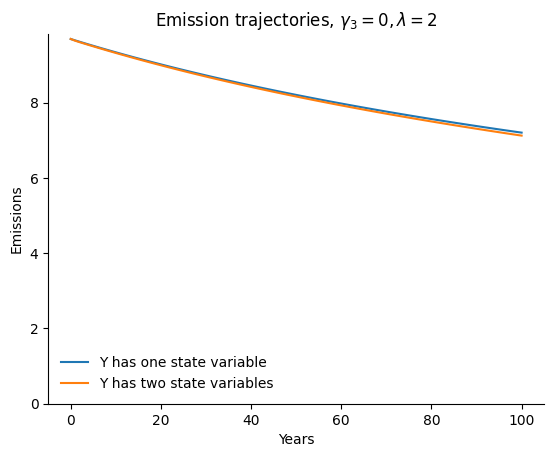

In [23]:
plt.title(f"Emission trajectories, $γ_3 = 0, λ = {λ}$")
plt.plot(et1, label="Y has one state variable")
plt.plot(et2, label="Y has two state variables")
plt.legend(frameon=False, loc=3)
plt.ylim(0)
plt.ylabel("Emissions")
plt.xlabel("Years")
# plt.savefig("ems_1_2_5")
plt.show()

In [44]:
et_prejump, y1t_prejump, y2t_prejump = simulation(y1_grid_cap,
                                                  y2_grid,
                                                  ems,
                                                  λ,
                                                  θ=np.mean(θ_list),
                                                  y1_0 = 1.1,
                                                  y2_0=np.mean(θ_list),
                                                  T=110
                                                 )

In [46]:
simul = {
    "et": et_prejump,
    "y1t": y1t_prejump,
    "y2t": y2t_prejump,
}

pickle.dump(simul, open("simul_2", "wb"))

In [47]:
y1t_prejump

array([1.1       , 1.10778465, 1.11630198, 1.12486182, 1.13337288,
       1.14182344, 1.15021235, 1.15853984, 1.16680635, 1.17501235,
       1.18315829, 1.19124462, 1.19927176, 1.20724014, 1.2151501 ,
       1.22300204, 1.23079639, 1.23853358, 1.24621401, 1.25383811,
       1.26140628, 1.26891893, 1.27637647, 1.28377931, 1.29112785,
       1.29842248, 1.3056636 , 1.31285159, 1.31998684, 1.32706974,
       1.33410054, 1.34107959, 1.3480073 , 1.35488404, 1.36171017,
       1.36848607, 1.37521211, 1.38188863, 1.38851602, 1.39509463,
       1.40162482, 1.40810699, 1.41454161, 1.42092903, 1.4272696 ,
       1.43356365, 1.43981152, 1.44601353, 1.45217175, 1.45828671,
       1.46435873, 1.47038807, 1.47637499, 1.48231974, 1.4882334 ,
       1.4941343 , 1.50002491, 1.50590557, 1.51177631, 1.51763713,
       1.52348801, 1.52939438, 1.53541096, 1.54154764, 1.54780812,
       1.55419519, 1.56071155, 1.56736681, 1.57422201, 1.58129156,
       1.58858345, 1.59610493, 1.60386311, 1.61187521, 1.62016

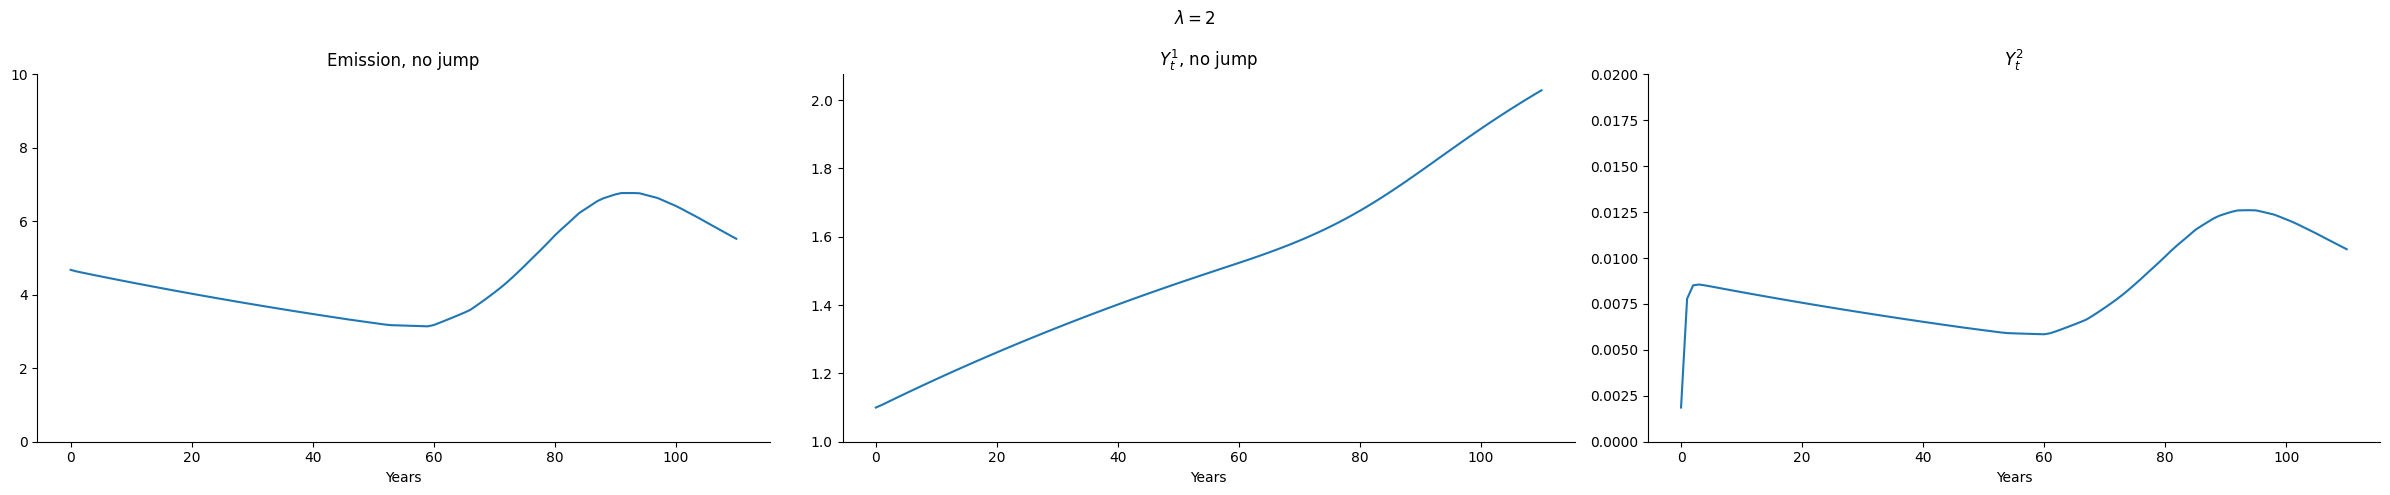

In [48]:
fig = plt.figure(figsize=(24, 5))
fig.suptitle(f"$\lambda = {λ}$")
plt.subplot(131)
plt.title("Emission, no jump")
plt.plot(et_prejump)
plt.ylim(0,10)
plt.xlabel("Years")
plt.subplot(132)
plt.xlabel("Years")
plt.title(r"$Y_t^1$, no jump")
plt.plot(y1t_prejump)
plt.ylim(1)
plt.subplot(133)
plt.title(r"$Y_t^2$")
plt.plot(y2t_prejump)
plt.ylim(0, 0.02)
plt.xlabel("Years")
plt.tight_layout()
# plt.savefig(f"e_y1_y2_{λ}")
plt.show()

In [41]:
y2_grid

array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
       0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
       0.018, 0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026,
       0.027, 0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035,
       0.036, 0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044,
       0.045, 0.046, 0.047, 0.048, 0.049])

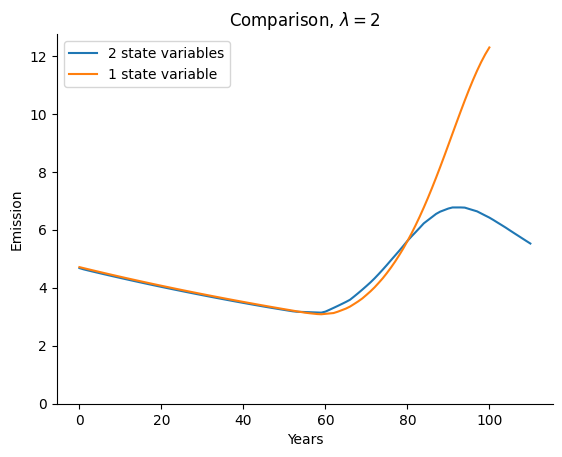

In [49]:
et_1state = np.load("et_1state.npy")
plt.plot(et_prejump, label="2 state variables")
plt.plot(et_1state, label="1 state variable")
plt.ylim(0)
plt.legend()
plt.xlabel("Years")
plt.ylabel("Emission")
plt.title(f'Comparison, $\lambda = {λ}$')
# plt.savefig(f"emissions_2_{λ}")
plt.show()

In [50]:
# simulate
def simulate_logkapital(invkap, αₖ,  σₖ, κ, k0, T=100, dt=1):
    periods = int(T/dt)
    Kt = np.zeros(periods)
    i = invkap
     # log capital
    Kt[0] = np.log(k0)
    k = np.log(k0)
    for t in range(periods-1):
        k +=   (αₖ + i - κ/2*i**2 - .5*σₖ**2)*dt
        Kt[t+1] = k
    return Kt

In [51]:
invkap = 0.09
α = 0.115
αₖ = - 0.043
σₖ = 0.0095
κ = 6.667
k0 = 85/α

In [54]:
Kt = simulate_logkapital(invkap, αₖ, σₖ, κ,  k0, T=111)
MC = δ*(1-η)/((α - invkap)*np.exp(Kt))
scc = η*(α - invkap)*np.exp(Kt)/(1-η)/et_prejump*1000

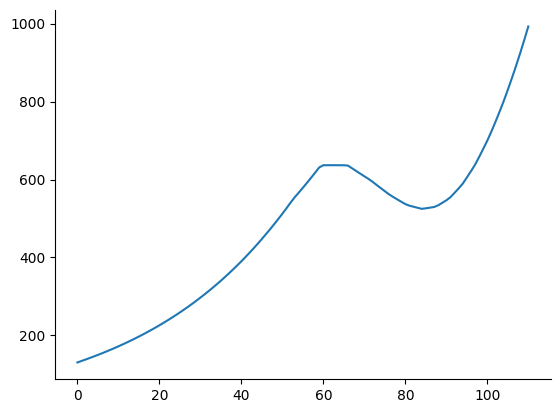

In [55]:
plt.plot(scc)
plt.show()

In [33]:
np.save(f"scct_{λ}", scc)